# Language Model Evaluation

In [1]:
EXPERIMENT_CONFIG = {
    "EXPERIMENT-NAME": "base", 
    "EXPERIMENT-VERSION": "v1",
}
LOG_DIR = "../logs/"
SAVED_MODEL_DIR = "../saved_models/"

## Version log

### base

Punto de partida


## Development

### Initialize

In [2]:
%matplotlib inline

import sys
import os

import time
import pickle
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow.keras as k
import tensorflow_hub as hub

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Bidirectional, Dense, Dropout
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint
from tensorflow.keras.utils import to_categorical

from sklearn.metrics import balanced_accuracy_score

### Experiment Config

In [3]:
EC = EXPERIMENT_CONFIG

EC["RANDOM_SEED"] = 12348
EC["DATASET_FN"] = "../data/es-train.csv"
EC["ROWS_TO_LOAD"] = 50000#None == all 
# how much data will reserve for test set (of the DS prop to use) (0.10)
EC["TEST_SET_SPLIT"] = 0.002

#TFHUB_EMB_MODEL = "https://tfhub.dev/google/universal-sentence-encoder/2" 
# download the module manually if network problems 
# like URLError: <urlopen error [Errno -3] Temporary failure in name resolution>
# check https://www.tensorflow.org/hub/common_issues 
#TFHUB_EMB_MODEL = "../tf_hub_cache/gnews-swivel-20dim-v1"

#TFHUB_EMB_MODEL = "https://tfhub.dev/google/nnlm-es-dim50-with-normalization/2" #
#TFHUB_EMB_MODEL_DIM = 50
EC["TFHUB-EMB_MODEL"] = "https://tfhub.dev/google/tf2-preview/nnlm-es-dim128-with-normalization/1"
EC["TFHUB-EMB_MODEL_DIM"] = 128

#Model parameters
EC["MODEL-LM_IS_TRAINABLE"] = True
EC["MODEL-DENSE_UNITS"] = 512
EC["MODEL-DENSE_ACTIVATION"] = "relu"
EC["MODEL-DENSE_DROPOUT_RATE"] = 0.25
EC["MODEL-OPTIMIZER"] = "Adam"
EC["MODEL-LOSS"] = 'sparse_categorical_crossentropy'

#Train parameters
EC["TRAIN-BATCH_SIZE"] = 1024
EC["TRAIN-EPOCHS"] = 1
EC["TRAIN-INITIAL_EPOCH"] = 0
# how much of the data will be used for validation (of the DS prop to use) (0.05)
EC["TRAIN-VALIDATION_SET_SPLIT"] = 0.0005

EC["RESULTS-HISTORIES"] = []

# specify a small proportion to speed things while testing, 1.0 when running full training
#DATASET_PROPORTION_TO_USE = 1.0

In [4]:
#initialize env
#seeds to make reproducible
#todo: check reproducibility
np.random.seed(EC["RANDOM_SEED"])
tf.random.set_seed(EC["RANDOM_SEED"])

pd.options.display.max_rows = 10

In [5]:
def show_env(as_string=True):
    my_env = []
    my_env.append(f"Host: {os.getenv('HOST_HOSTNAME')}_{os.getenv('HOSTNAME')}")
    a = !uname -a
    my_env.append(f"OS: {a[0]}")
    my_env.append(f"Python: {sys.version}")
    my_env.append(f"Tensorflow: {tf.__version__}")
    if len(tf.config.list_physical_devices("GPU")):
        my_env.append("GPU: available")
        a=!nvidia-smi -L
        my_env.append("\n".join(a))
    else:
        my_env.append("GPU: not available")
    my_env.append(f"Keras: {tf.keras.__version__}")
    my_env.append(f"TFHub: {hub.__version__}")
    if as_string:
        my_env = "\n".join(my_env)
    return my_env

## Load and prepare datasets

In [6]:
df = pd.read_csv(EC['DATASET_FN'], 
                 nrows = EC['ROWS_TO_LOAD']).dropna(axis=0).sample(frac=1).reset_index()
df = df[["title", "category"]]
df.head()

,title,category
0,Aspirador Cocina Llanos Classic 60cm Acero Com...,KITCHEN_RANGE_HOODS
1,Auto A Bateria Niños Cars Disney 12v Mp3 Cont...,POWERED_RIDE_ON_TOYS
2,Estados Unidos Adaptador Cargador Para Lg Tota...,MOBILE_DEVICE_CHARGERS
3,Linterna Recargable Ledlenser P7r 1000 Lumens ...,FLASHLIGHTS
4,Liquido Sintoamplificador Teac Vintage Ag360!,AV_RECEIVERS


In [7]:
output_dim = len(df["category"].unique())
print(f"Unique categories: {output_dim}")

Unique categories: 1533


In [8]:
cat_dict = dict(zip(df["category"].unique(), np.arange(output_dim)))
inverse_cat_dict = dict(zip(cat_dict.values(), cat_dict.keys()))
labels = df["category"].map(cat_dict)

### Split datasets

In [9]:
num_samples = len(df)
num_test_samples = int(num_samples * EC["TEST_SET_SPLIT"])
num_training_samples = num_samples - num_test_samples

training_set_data = df["title"].head(num_training_samples)
training_set_labels = labels[:num_training_samples]
test_set_data = df["title"].tail(num_test_samples)
test_set_labels = labels[-num_test_samples:]

print(f"Training set shape: {training_set_data.shape}")
print(f"Training labels shape: {training_set_labels.shape}")
print(f"Test set shape: {test_set_data.shape}")
print(f"Test labels shape: {test_set_labels.shape}")

Training set shape: (49900,)
Training labels shape: (49900,)
Test set shape: (100,)
Test labels shape: (100,)


### Build Model

In [10]:
## load TF Hub embedding module
hub_layer = hub.KerasLayer(EC["TFHUB-EMB_MODEL"], 
                           output_shape=[EC["TFHUB-EMB_MODEL_DIM"]], 
                           input_shape=[], 
                           trainable=EC["MODEL-LM_IS_TRAINABLE"], 
                           dtype=tf.string,
                           name="LANG_MODEL") 
#hub_layer(np.array(training_set_data[:3]))

In [11]:
model = Sequential(name = f"{EC['EXPERIMENT-NAME']}-{EC['EXPERIMENT-VERSION']}")
model.add(hub_layer)
model.add(Dense(units = EC["MODEL-DENSE_UNITS"], 
                activation = EC["MODEL-DENSE_ACTIVATION"],  
                name = "DEN_1"))
model.add(Dropout(rate = EC["MODEL-DENSE_DROPOUT_RATE"],
                 name = "DROP_1"))
model.add(Dense(units = EC["MODEL-DENSE_UNITS"], 
                activation = EC["MODEL-DENSE_ACTIVATION"],  
                name = "DEN_2"))
model.add(Dropout(rate = EC["MODEL-DENSE_DROPOUT_RATE"],
                 name="DROP_2"))

model.add(Dense(output_dim, activation="softmax", name="DEN_OUT"))

model.compile(optimizer=EC["MODEL-OPTIMIZER"], 
              loss=EC["MODEL-LOSS"])
EC["MODEL-SUMMARY"] = []
model.summary(print_fn = lambda x: EC["MODEL-SUMMARY"].append(x))
model.summary()

Model: "base-v1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
LANG_MODEL (KerasLayer)      (None, 128)               125009920 
_________________________________________________________________
DEN_1 (Dense)                (None, 512)               66048     
_________________________________________________________________
DROP_1 (Dropout)             (None, 512)               0         
_________________________________________________________________
DEN_2 (Dense)                (None, 512)               262656    
_________________________________________________________________
DROP_2 (Dropout)             (None, 512)               0         
_________________________________________________________________
DEN_OUT (Dense)              (None, 1533)              786429    
Total params: 126,125,053
Trainable params: 126,125,053
Non-trainable params: 0
_____________________________________________

### Train and Test

In [12]:
#run params
runid = "%s-%s-%s"%\
    (EC["EXPERIMENT-NAME"],
     EC["EXPERIMENT-VERSION"],
     time.strftime(time.strftime('%y%m%d_%H%M',time.localtime())))

EC["EXPERIMENT-RUNID"] = runid

#Create saved model dir     
directory = SAVED_MODEL_DIR+"/"+runid
if not os.path.exists(directory):
    os.makedirs(directory)
EC["EXPERIMENT-SAVE_DIR"] = directory

EC["EXPERIMENT-LOG_DIR"] = f"{LOG_DIR}/{runid}"
EC["EXPERIMENT-BEST_MODEL_FN"] = f"{directory}/model.hdf5"

EC["EXPERIMENT-ENVIRONMENT"]  = show_env(as_string=False)

print(show_env())
print(f"runid: {runid}")

Host: ttmagpie_ce5e64a71094
OS: Linux ce5e64a71094 5.0.0-37-generic #40~18.04.1-Ubuntu SMP Thu Nov 14 12:06:39 UTC 2019 x86_64 x86_64 x86_64 GNU/Linux
Python: 3.6.9 (default, Nov  7 2019, 10:44:02) 
[GCC 8.3.0]
Tensorflow: 2.1.0
GPU: not available
Keras: 2.2.4-tf
TFHub: 0.7.0
runid: base-v1-200118_0039


In [13]:
print('Training...')

tensorboard = TensorBoard(log_dir=EC["EXPERIMENT-LOG_DIR"])
checkpoint = ModelCheckpoint(EC["EXPERIMENT-BEST_MODEL_FN"], 
                             monitor='val_loss',
                             verbose=1, save_best_only=True, mode="min")

# train
t0 = time.time()
EC["EXPERIMENT-STARTED_AT"] = t0
print("Start:" + time.strftime("%Y%m%d_%H%M", time.localtime()))
history = model.fit(np.array(training_set_data), 
          training_set_labels,
          batch_size = EC["TRAIN-BATCH_SIZE"],
          epochs = EC["TRAIN-EPOCHS"],
          initial_epoch = EC["TRAIN-INITIAL_EPOCH"],
          validation_split = EC["TRAIN-VALIDATION_SET_SPLIT"],
          verbose=1,
          callbacks=[tensorboard, checkpoint])

tfin = time.time()
EC["EXPERIMENT-FINISHED_AT"] = tfin
print("End:" + time.strftime("%Y%m%d_%H%M",time.localtime()))
ttook = tfin - t0 
EC["EXPERIMENT-TRAINIG_TOOK"] = ttook
print(f"{ttook} sec, {ttook/60} min, {ttook/3600} hrs")

Training...
Start:20200118_0039
Train on 49875 samples, validate on 25 samples
49152/49875 [============================>.] - ETA: 0s - loss: 7.0091
Epoch 00001: val_loss improved from inf to 6.39506, saving model to ../saved_models//base-v1-200118_0039/model.hdf5
49875/49875 [==============================] - 68s 1ms/sample - loss: 7.0033 - val_loss: 6.3951
End:20200118_0040
68.08005905151367 sec, 1.1346676508585611 min, 0.018911127514309352 hrs


In [14]:
EC["RESULTS-HISTORIES"].append(history.history)

## Test

In [15]:
#Use last model
analysis_model = model
#Load best model
#analysis_model = tf.keras.models.load_model(directory+"/model.hdf5", 
#                                            custom_objects={
#                                                "KerasLayer":hub_layer
#                                            })
print("Predict:")
predictions = analysis_model.predict(np.array(test_set_data), verbose=1)

Predict:
100/100 [==============================] - 1s 11ms/sample


In [16]:
#predictions[0]

In [17]:
inverse_cat_dict = dict(zip(cat_dict.values(), cat_dict.keys()))
predicted_categories = [inverse_cat_dict[np.argmax(p)] for p in predictions]
#predicted_categories

In [18]:
real_categories = [inverse_cat_dict[p] for p in test_set_labels]
#real_categories

### Balanced Accuracy

In [19]:
bac = balanced_accuracy_score(real_categories, predicted_categories)
EC["RESULTS-BALANCED_ACCURACY"] = bac
bac

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1859: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')


0.010638297872340425

### Save results with metadata

In [20]:
EC

{'EXPERIMENT-NAME': 'base',
 'EXPERIMENT-VERSION': 'v1',
 'RANDOM_SEED': 12348,
 'DATASET_FN': '../data/es-train.csv',
 'ROWS_TO_LOAD': 50000,
 'TEST_SET_SPLIT': 0.002,
 'TFHUB-EMB_MODEL': 'https://tfhub.dev/google/tf2-preview/nnlm-es-dim128-with-normalization/1',
 'TFHUB-EMB_MODEL_DIM': 128,
 'MODEL-LM_IS_TRAINABLE': True,
 'MODEL-DENSE_UNITS': 512,
 'MODEL-DENSE_ACTIVATION': 'relu',
 'MODEL-DENSE_DROPOUT_RATE': 0.25,
 'MODEL-OPTIMIZER': 'Adam',
 'MODEL-LOSS': 'sparse_categorical_crossentropy',
 'TRAIN-BATCH_SIZE': 1024,
 'TRAIN-EPOCHS': 1,
 'TRAIN-INITIAL_EPOCH': 0,
 'TRAIN-VALIDATION_SET_SPLIT': 0.0005,
 'RESULTS-HISTORIES': [{'loss': [7.003328372955322],
   'val_loss': [6.395055770874023]}],
 'MODEL-SUMMARY': ['Model: "base-v1"',
  '_________________________________________________________________',
  'Layer (type)                 Output Shape              Param #   ',
  '=================================================================',
  'LANG_MODEL (KerasLayer)      (None, 128)

In [21]:
meta_fn = f"{EC['EXPERIMENT-SAVE_DIR']}/experiment-metadata.json"
EC["EXPERIMENT-METADATA_FN"] = meta_fn
with open(meta_fn, "wt") as fo:
    fo.write(json.dumps(EC))

### History graphs

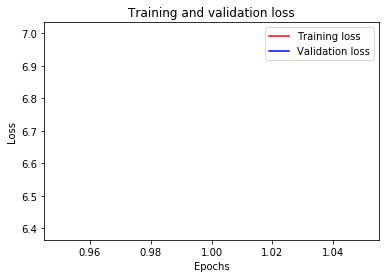

In [22]:
history_dict = history.history
loss = history_dict['loss']
val_loss = history_dict['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

## Results Analysis

In [24]:
test = pd.DataFrame({
    'title':np.array(test_set_data),
    'real':real_categories,
    'predicted':predicted_categories
})
#test

In [25]:
pd.options.display.max_rows = 50
test.head(50)

,title,real,predicted,real_str,predicted_str
0,Mesas Y Sillas,DINING_SETS,BOARD_GAMES,610,65
1,Sensei Grupo Electrogeno Dogo Ec2500a 2.3kv 4t,PORTABLE_GENERATORS,SPARK_PLUGS,685,434
2,Tubo Brida Valv Venteo Carter Chevrolet 100% S...,ENGINE_INTAKE_HOSES,SPARK_PLUGS,320,434
3,"Burlete De Portón Peugeot 307 5p, Sealpro Por ...",AUTOMOTIVE_WEATHERSTRIPS,SPARK_PLUGS,737,434
4,Portacosmeticos Cuero Prune,TOILETRY_BAGS,LOAFERS_AND_OXFORDS,599,179
5,Anafe Electrico Vitroceramico Fagor - 2 Areas ...,COOKTOPS,SPARK_PLUGS,958,434
6,Centro Volante Direccion Gol Iv -saveiro,AUTOMOTIVE_STEERING_WHEELS,SPARK_PLUGS,204,434
7,Sensor De Presión Map Volkswagen Suran (10') 1...,MAP_SENSORS,SPARK_PLUGS,282,434
8,Cera Sheen Wax X100grs The Hunter Barberia Caj...,HAIR_MOLDING_AND_STYLING,POSTERS,1062,129
9,Cemento De Contacto 101 Fortex X 1 L Pegamento,SCHOOL_AND_OFFICE_GLUES,BOARD_GAMES,695,65


In [26]:
test.to_csv(directory+"/test-results.csv", index=False)

In [27]:
with open(directory+"/inverse_cat_dict.pickle", "wb") as fo:
    pickle.dump(inverse_cat_dict, fo)

In [28]:
with open(directory+"/predictions.pickle", "wb") as fo:
    pickle.dump(predictions, fo)